###Load required libraries and datasets

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt
import seaborn as sn

file1 = "QVI_transaction_data.xlsx"
file2 = "QVI_purchase_behaviour.csv"
transactionData = pd.read_excel(file1)
customerData = pd.read_csv(file2)

###Exploratory data analysis
The first step in my analysis was to understand the data. I started by examining each of the datasets provided.

####Examining transaction data

In [ ]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


It was observed that the date column was in an integer format. So i had to change this to a date format.

In [ ]:
# Convert DATE column to a date format
# A quick Google search tells us that CSV and Excel integer dates begin on 30 Dec 1899
transactionData['DATE'] = pd.to_datetime(transactionData['DATE'], origin='1899-12-30', unit='D')

In [ ]:
# Making sure the DATE column is well formated
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


Examine the PROD_NAME column.

In [ ]:
transactionData['PROD_NAME'].value_counts()

Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
                                            ... 
RRD Pc Sea Salt     165g                    1431
Woolworths Medium   Salsa 300g              1430
NCC Sour Cream &    Garden Chives 175g      1419
French Fries Potato Chips 175g              1418
WW Crinkle Cut      Original 175g           1410
Name: PROD_NAME, Length: 114, dtype: int64

As I am examining potato chips. To confirm if all items belonged to the chips category, I opted for basic text analysis by summarizing the individual words in the product name.

In [ ]:
# Examine the words in PROD_NAME to see if there are any incorrect entries such as products that are not chips
# Splitting the 'PROD_NAME' column into individual words
unique_product_names = transactionData['PROD_NAME'].unique()
productWords= [word for name in unique_product_names for word in str(name).split()]

Since my focus was solely on words indicating whether the product is chips or not, I removed all words containing digits and special characters like '&' from our set of product words. This was achieved using regular expressions in python.

In [ ]:
# Creating a DataFrame to store unique words
product_words_df = pd.DataFrame({'words': productWords})
product_words_df.head()

,words
0,Natural
1,Chip
2,Compny
3,SeaSalt175g
4,CCs


In [ ]:
# Function to check for digits and special characters in a row
def contains_special_chars(words):
    return bool(re.search(r'[0-9&]', words))

# Apply the function to check for rows containing digits or '&' character
mask = product_words_df['words'].apply(contains_special_chars)

# Filter the DataFrame to exclude rows containing digits or '&'
product_words_df = product_words_df[~mask]
product_words_df.head()

,words
0,Natural
1,Chip
2,Compny
4,CCs
5,Nacho


In [ ]:
# Displaying unique words and their frequencies
unique_words_frequency = product_words_df['words'].value_counts()
print(unique_words_frequency)

Chips        21
Smiths       16
Crinkle      14
Cut          14
Kettle       13
             ..
Camembert     1
PotatoMix     1
Pesto         1
Basil         1
Bolognese     1
Name: words, Length: 171, dtype: int64


In the dataset, there were salsa products present, but my interest was exclusively in the chips category. So salsa products were removed from consideration.

In [ ]:
# Filtering out salsa products
transactionData = transactionData[~transactionData['PROD_NAME'].str.lower().str.contains('salsa')].reset_index(drop=True)

Following that, I utilized the 'describe()' function to review summary statistics, such as mean, minimum, and maximum values for each feature. This helped in identifying potential outliers in the data and i also checked for any null values present in the columns.

In [ ]:
# Summary statistics
transactionData.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [ ]:
# Checking for null values in the dataset
null_counts = transactionData.isnull().sum()
print(null_counts)

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


There were no null values detected in the columns. However, it seemed that there was an outlier in the product quantity column that required further investigation. Specifically, I chose to investigate the case where 200 packets of chips were purchased in a single transaction.

In [ ]:
# Filter the dataset to find the outlier where 200 packets of chips are bought
outlier_transactions = transactionData[transactionData['PROD_QTY'] == 200]
outlier_transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
64955,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
64956,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There are two transactions where 200 packets of chips are bought in one transaction and both of these
transactions where by the same customer.

In [ ]:
# To see if the customer has had other transactions
outlier_customer = transactionData[transactionData['LYLTY_CARD_NBR'] == 226000]
outlier_customer.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
64955,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
64956,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It appeared that this customer had only conducted two transactions throughout the year, suggesting they might not be a typical retail customer. It seemed plausible that the customer could be purchasing chips for commercial purposes instead. So I decided to exclude this loyalty card number from any further analysis.

In [ ]:
# Filter out the customer based on the loyalty card number
transactionData = transactionData[transactionData['LYLTY_CARD_NBR'] != 226000]

In [ ]:
transactionData.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


 Moving forward, I proceeded to examine the number of transaction lines over time to identify any potential data issues, such as missing data, in the dataset.

In [ ]:
# Count the number of transactions by date
transaction_counts_by_date = transactionData.groupby('DATE').size().reset_index(name='Transaction_Count')
print(transaction_counts_by_date)

          DATE  Transaction_Count
0   2018-07-01                663
1   2018-07-02                650
2   2018-07-03                674
3   2018-07-04                669
4   2018-07-05                660
..         ...                ...
359 2019-06-26                657
360 2019-06-27                669
361 2019-06-28                673
362 2019-06-29                703
363 2019-06-30                704

[364 rows x 2 columns]


With only 364 rows present, signifying 364 dates, it indicates a missing date within the dataset. To resolve this, I generated a sequence of dates from July 1, 2018, to June 30, 2019. This sequence was utilized to create a chart illustrating the number of transactions over time, which assisted in identifying the missing date.

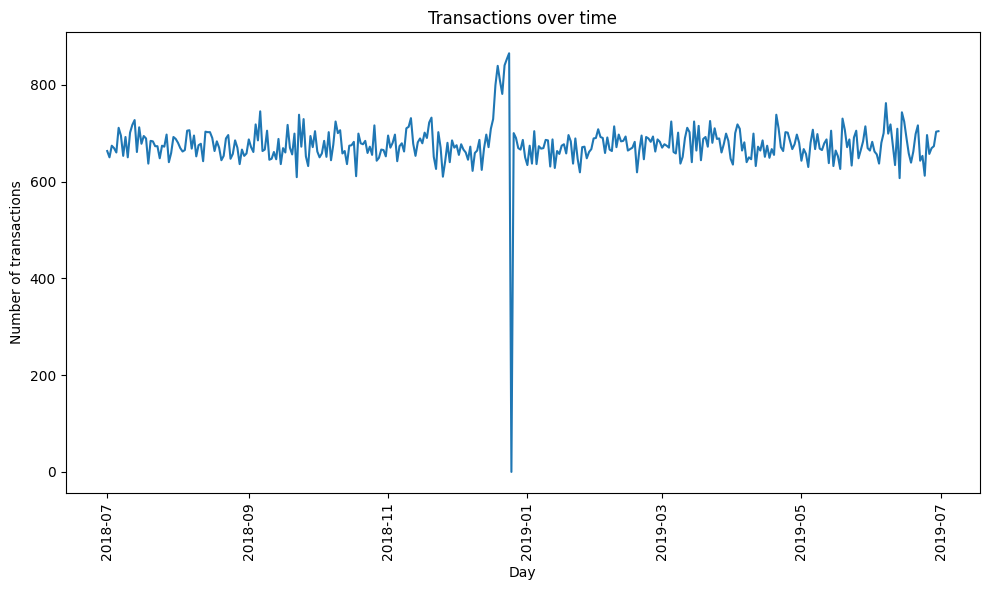

In [ ]:
# Create a sequence of dates
all_dates = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')
all_dates_df = pd.DataFrame({'DATE': all_dates})

# Merge the sequence of dates with transaction counts
transactions_by_day = all_dates_df.merge(transaction_counts_by_date, on='DATE', how='left')
transactions_by_day['Transaction_Count'].fillna(0, inplace=True)  # Fill missing counts with 0

# Plot transactions over time
plt.figure(figsize=(10, 6))
plt.plot(transactions_by_day['DATE'], transactions_by_day['Transaction_Count'])
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.title('Transactions over time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Upon observation, there appears to be a rise in purchases during December, followed by a pause towards the end of December. To gain more insight, I decided to focus or "zoom in" on this specific period for further analysis.

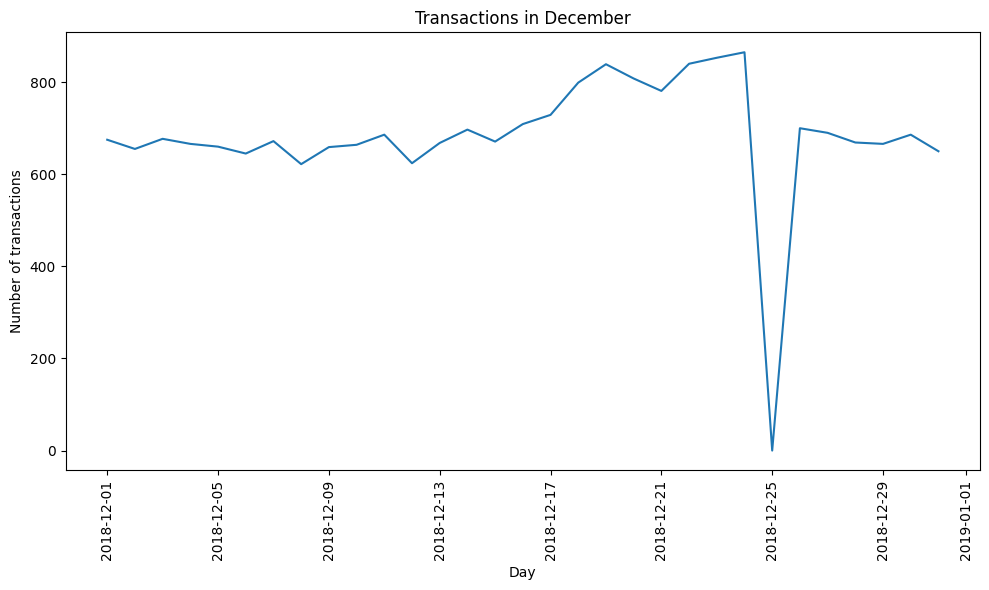

In [ ]:
# Filter data for December
december_data = transactions_by_day[transactions_by_day['DATE'].dt.month == 12]

# Plot transactions over individual days in December
plt.figure(figsize=(10, 6))
plt.plot(december_data['DATE'], december_data['Transaction_Count'])
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.title('Transactions in December')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The surge in sales appears to happen in the period leading up to Christmas, and notably, there are zero sales recorded on Christmas day itself, presumably because shops are closed on that day. Having addressed the outliers in the data, I'm now prepared to proceed with creating additional features, such as determining the brand of chips or pack size derived from the PROD_NAME column. Beginning with pack size seems to be the logical step.

In [ ]:
# Extract pack sizes using regular expressions
transactionData['PACK_SIZE'] = transactionData['PROD_NAME'].str.extract(r'(\d+)')
transactionData['PACK_SIZE'] = transactionData['PACK_SIZE'].astype(float)

# Display count of pack sizes and their frequency
pack_size_counts = transactionData['PACK_SIZE'].value_counts().reset_index()
pack_size_counts.columns = ['PACK_SIZE', 'Frequency']
pack_size_counts = pack_size_counts.sort_values('PACK_SIZE')
print(pack_size_counts)

    PACK_SIZE  Frequency
17       70.0       1507
13       90.0       3008
3       110.0      22387
19      125.0       1454
2       134.0      25102
11      135.0       3257
1       150.0      40203
15      160.0       2970
5       165.0      15297
4       170.0      19983
0       175.0      66390
18      180.0       1468
14      190.0       2995
10      200.0       4473
9       210.0       6272
16      220.0       1564
12      250.0       3169
8       270.0       6285
6       330.0      12540
7       380.0       6416


The largest size is 380g and the smallest size is 70g - seems sensible!

I plotted a histogram of PACK_SIZE since I knew that it is a categorical variable and not a continuous variable even though it is numeric.

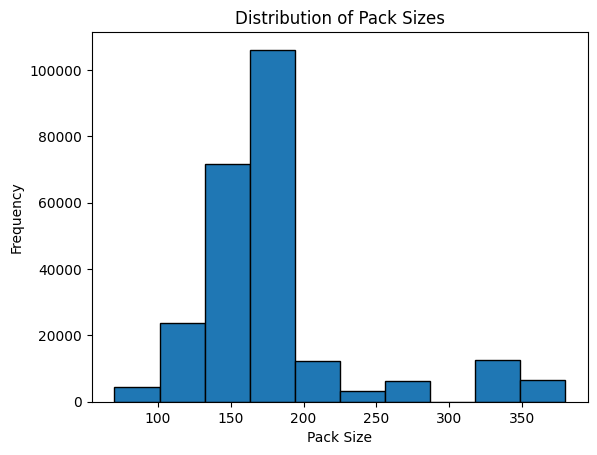

In [ ]:
# Plotting a histogram for the PACK_SIZE column
plt.hist(transactionData['PACK_SIZE'], bins=10, edgecolor='black')
plt.xlabel('Pack Size')
plt.ylabel('Frequency')
plt.title('Distribution of Pack Sizes')
plt.show()


The pack sizes generated seem reasonable. To extract brand names from the data, I utilized the first word in the PROD_NAME column to determine the brand name for each product.

In [ ]:
# Create a new 'BRAND' column by extracting the first word from 'PROD_NAME'
transactionData['BRAND'] = transactionData['PROD_NAME'].str.split().str[0].str.upper()

# Check the frequency of each brand
brand_counts = transactionData['BRAND'].value_counts().reset_index()
brand_counts.columns = ['BRAND', 'Frequency']
brand_counts = brand_counts.sort_values(by='Frequency', ascending=False)
print(brand_counts)

         BRAND  Frequency
0       KETTLE      41288
1       SMITHS      27390
2     PRINGLES      25102
3      DORITOS      22041
4        THINS      14075
5          RRD      11894
6    INFUZIONS      11057
7           WW      10320
8         COBS       9693
9     TOSTITOS       9471
10    TWISTIES       9454
11    TYRRELLS       6442
12       GRAIN       6272
13     NATURAL       6050
14    CHEEZELS       4603
15         CCS       4551
16         RED       4427
17      DORITO       3183
18      INFZNS       3144
19       SMITH       2963
20     CHEETOS       2927
21       SNBTS       1576
22      BURGER       1564
23  WOOLWORTHS       1516
24     GRNWVES       1468
25    SUNBITES       1432
26         NCC       1419
27      FRENCH       1418


some of the brand names had errors so i corrected them

In [ ]:
# Clean brand names
transactionData.loc[transactionData['BRAND'].isin(['RED']), 'BRAND'] = 'RRD'
transactionData.loc[transactionData['BRAND'].isin(['DORITO']), 'BRAND'] = 'DORITOS'
transactionData.loc[transactionData['BRAND'].isin(['SMITH']), 'BRAND'] = 'SMITHS'
transactionData.loc[transactionData['BRAND'].isin(['SNBTS']), 'BRAND'] = 'SUNBITES'
transactionData.loc[transactionData['BRAND'].isin(['INFZNS']), 'BRAND'] = 'INFUZIONS'
transactionData.loc[transactionData['BRAND'].isin(['WW']), 'BRAND'] = 'WOOLWORTHS'
transactionData.loc[transactionData['BRAND'].isin(['NCC']), 'BRAND'] = 'NATURAL'
transactionData.loc[transactionData['BRAND'].isin(['GRAIN']), 'BRAND'] = 'GRNWVES'

In [ ]:
# Recheck
transactionData['BRAND'].value_counts()

KETTLE        41288
SMITHS        30353
DORITOS       25224
PRINGLES      25102
RRD           16321
INFUZIONS     14201
THINS         14075
WOOLWORTHS    11836
COBS           9693
TOSTITOS       9471
TWISTIES       9454
GRNWVES        7740
NATURAL        7469
TYRRELLS       6442
CHEEZELS       4603
CCS            4551
SUNBITES       3008
CHEETOS        2927
BURGER         1564
FRENCH         1418
Name: BRAND, dtype: int64

####Examining customer data

In [ ]:
customerData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
# Summary
customerData.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [ ]:
# Examining the values of lifestage
customerData['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [ ]:
# Examining the values of premium_customer
customerData['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

No issues with the customer data was found,so i decided to merge the transaction and customer datasets together.

In [ ]:
# Merge transaction data to customer data
data = pd.merge(transactionData, customerData, how='left', on='LYLTY_CARD_NBR')
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,KETTLE,MIDAGE SINGLES/COUPLES,Budget


In [ ]:
# Check the number of rows in the merged 'data' DataFrame
print("Number of rows in data:", len(data))

# Verify for any potential duplicates by comparing row counts
if len(data) == len(transactionData):
    print("No duplicates were created.")
else:
    print("Duplicates might exist.")

Number of rows in data: 246740
No duplicates were created.


In [ ]:
# Check for missing customer details (nulls)
missing_customers = data[data['LYLTY_CARD_NBR'].isnull()]

if missing_customers.empty:
    print("All transactions have matched customer details.")
else:
    print("Transactions without matched customer details:")
    print(missing_customers)

All transactions have matched customer details.


In [ ]:
# Save the 'data' DataFrame as a CSV file for further analysis
data.to_csv('QVI_data.csv', index=False)

###Data analysis on customer segments

Now that the data is prepared for analysis, I defined some metrics of interest for the client:

1. Identifying the highest spenders on chips (total sales) and describing customers based on their lifestage and the level of premium in their general purchasing behavior.

2. Determining the count of customers in each segment.

3. Analyzing the quantity of chips purchased per customer within each segment.

4. Calculating the average chip price per customer segment.

Additional information i can gather from the data includes:

5. Total spend by the customer over the period and the spend for each transaction to comprehend the proportion of their overall grocery expenditure allocated to chips.

6. Percentage of customers within each customer segment to compare against the customer mix purchasing chips.

I started by computing total sales categorized by LIFESTAGE and PREMIUM_CUSTOMER. Subsequently, I'll visualize the distribution across these segments to identify which customer segment contributes the most to chip sales.

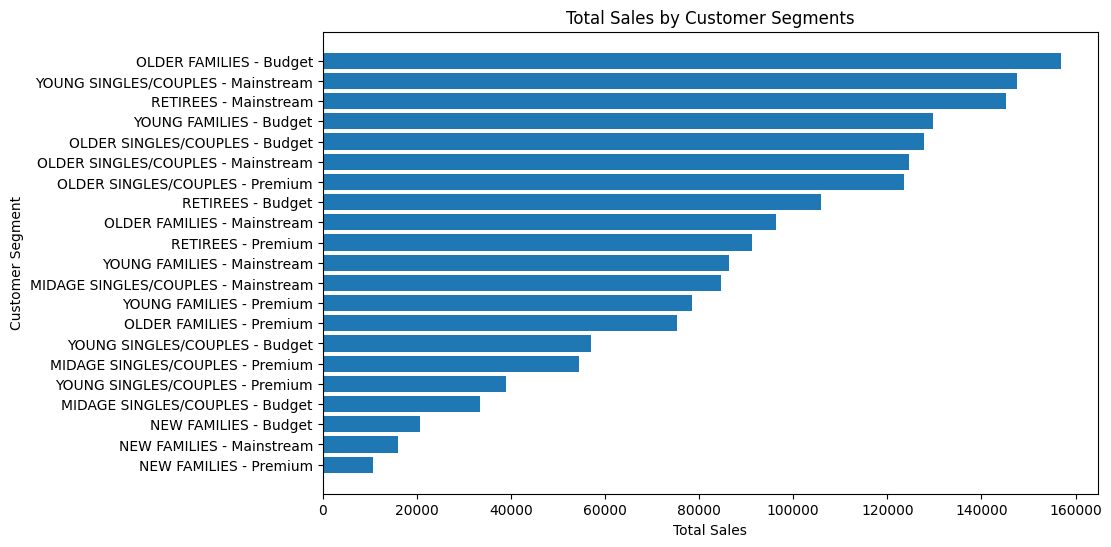

In [ ]:
# Calculate total sales by 'LIFESTAGE' and 'PREMIUM_CUSTOMER'
sales_summary = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Sort the sales_summary DataFrame by 'TOT_SALES' column in descending order
sales_summary = sales_summary.sort_values(by='TOT_SALES', ascending=False)

# Plotting the total sales with sorted values
plt.figure(figsize=(10, 6))
plt.barh(sales_summary['LIFESTAGE'] + ' - ' + sales_summary['PREMIUM_CUSTOMER'], sales_summary['TOT_SALES'])
plt.xlabel('Total Sales')
plt.ylabel('Customer Segment')
plt.title('Total Sales by Customer Segments')
plt.gca().invert_yaxis()  # Invert y-axis to display labels properly
plt.show()

Sales are coming mainly from older families-Bugdet, young singles/couples-Mainstream, and retirees-Mainstream.

Next i had to examine whether the increased sales are a result of having a higher number of customers who purchase chips.

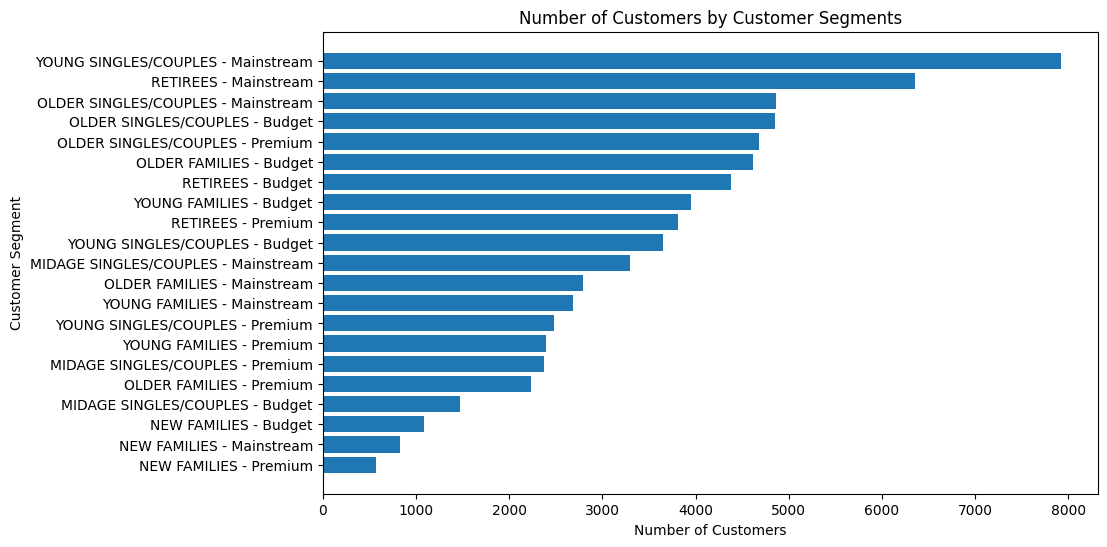

In [ ]:
# Calculate the number of customers by 'LIFESTAGE' and 'PREMIUM_CUSTOMER'
customer_count = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()

# Sort the customer_count DataFrame by 'LYLTY_CARD_NBR' column in descending order
customer_count = customer_count.sort_values(by='LYLTY_CARD_NBR', ascending=False)

# Plotting the number of customers with sorted values
plt.figure(figsize=(10, 6))
plt.barh(customer_count['LIFESTAGE'] + ' - ' + customer_count['PREMIUM_CUSTOMER'], customer_count['LYLTY_CARD_NBR'])
plt.xlabel('Number of Customers')
plt.ylabel('Customer Segment')
plt.title('Number of Customers by Customer Segments')
plt.gca().invert_yaxis()  # Invert y-axis to display labels properly
plt.show()

More customers in the young singles/couples-Mainstream and retirees-Mainstream segments tend to purchase chips. Consequently, these segments contribute to higher sales. However, this trend is not a significant factor for the Older families-Budget segment in driving sales.

Increased sales might also be influenced by a higher quantity of chips purchased per customer. So i examined this aspect next.

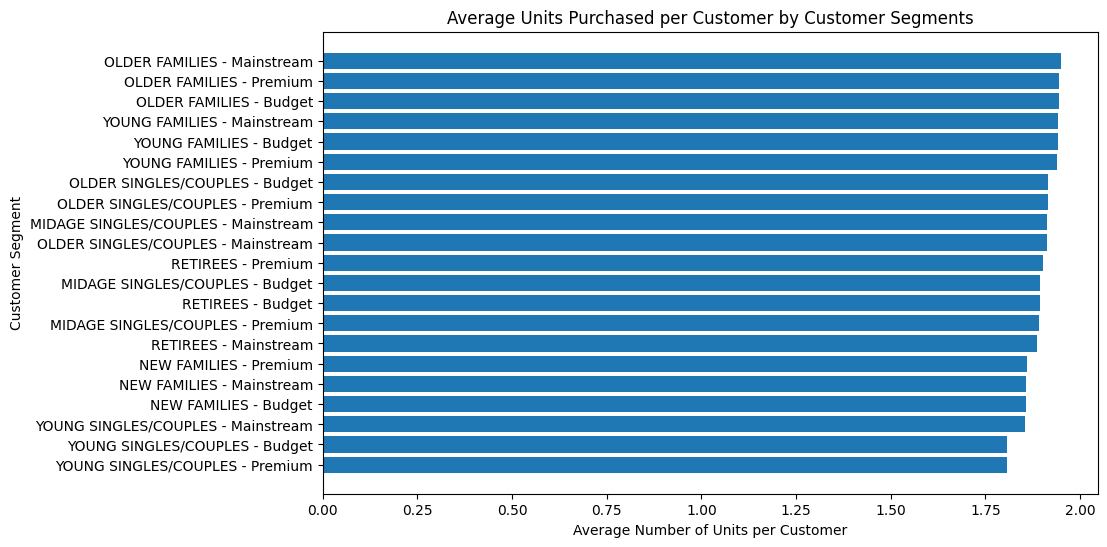

In [ ]:
# Calculate the average number of units per customer by 'LIFESTAGE' and 'PREMIUM_CUSTOMER'
average_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean().reset_index()

# Sort the average_units DataFrame by 'PROD_QTY' column in descending order
average_units = average_units.sort_values(by='PROD_QTY', ascending=False)

# Plotting the average number of units per customer with sorted values
plt.figure(figsize=(10, 6))
plt.barh(average_units['LIFESTAGE'] + ' - ' + average_units['PREMIUM_CUSTOMER'], average_units['PROD_QTY'])
plt.xlabel('Average Number of Units per Customer')
plt.ylabel('Customer Segment')
plt.title('Average Units Purchased per Customer by Customer Segments')
plt.gca().invert_yaxis()  # Invert y-axis to display labels properly
plt.show()

Older families and young families, in general, tend to buy more chips per customer. Additionally, I explored the average price per unit of chips purchased for each customer segment, as this factor also contributes to the total sales.

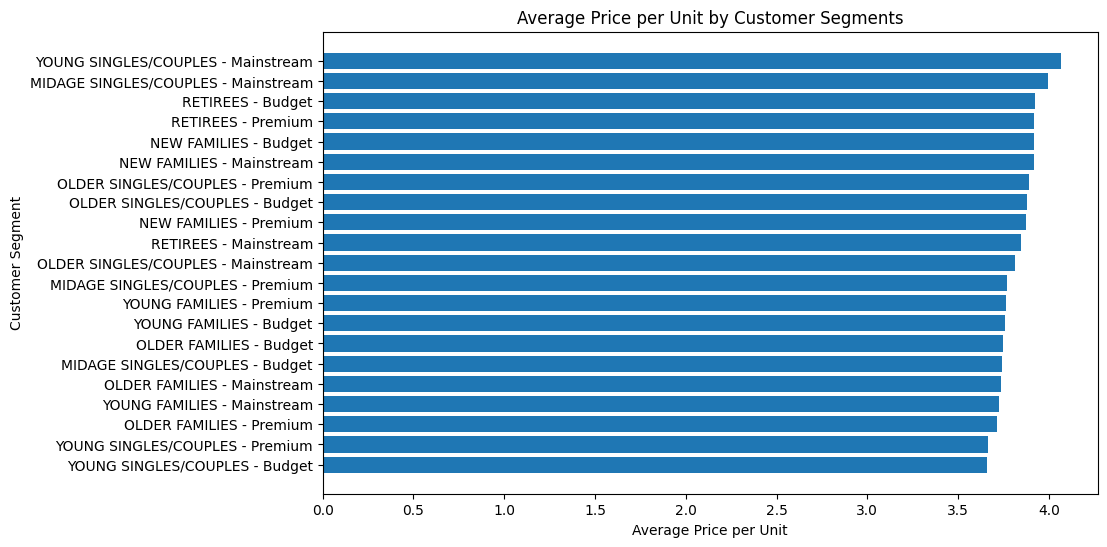

In [ ]:
# Calculate the average price per unit (average sale price) by 'LIFESTAGE' and 'PREMIUM_CUSTOMER'
data['SALES'] = data['TOT_SALES'] / data['PROD_QTY']  # Calculate sales per unit
average_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['SALES'].mean().reset_index()

# Sort the average_price DataFrame by 'SALES' column in descending order
average_price = average_price.sort_values(by='SALES', ascending=False)

# Plotting the average price per unit by customer segment with sorted values
plt.figure(figsize=(10, 6))
plt.barh(average_price['LIFESTAGE'] + ' - ' + average_price['PREMIUM_CUSTOMER'], average_price['SALES'])
plt.xlabel('Average Price per Unit')
plt.ylabel('Customer Segment')
plt.title('Average Price per Unit by Customer Segments')
plt.gca().invert_yaxis()  # Invert y-axis to display labels properly
plt.show()

Mainstream mid-age individuals and young singles and couples generally show a higher willingness to pay more per packet of chips in comparison to their budget and premium counterparts. This inclination might be attributed to premium shoppers being more inclined to purchase healthier snacks. When they do buy chips, it's often for entertainment purposes rather than personal consumption. This observation aligns with the lower frequency of purchases of chips by premium mid-age individuals and young singles and couples compared to their mainstream counterparts.

Although the discrepancy in average price per unit isn't substantial, it was beneficial to ascertain whether this difference is statistically significant.

In [ ]:
from scipy.stats import ttest_ind

# Calculate price per unit
data['price'] = data['TOT_SALES'] / data['PROD_QTY']

# Define conditions for filtering the data
mainstream_condition = data['PREMIUM_CUSTOMER'] == 'Mainstream'
lifestage_condition = data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])

# Filter data based on conditions
mainstream_group = data[mainstream_condition & lifestage_condition]['price']
other_group = data[~mainstream_condition & lifestage_condition]['price']

# Perform independent t-test
t_stat, p_value = ttest_ind(mainstream_group, other_group, alternative='greater')

print(f"T-statistic: {t_stat}, p-value: {p_value}")

T-statistic: 37.83196107667815, p-value: 1.11782280577468e-309


The t-test yielded a p-value < 2.2e-16, indicating that the unit price for mainstream, young, and mid-age singles and couples is significantly higher than that of budget or premium, young, and mid-age singles and couples.

I've discovered several intriguing insights that warrant deeper exploration. To potentially target customer segments that significantly contribute to sales for retention or to further enhance sales, I focused on examining Mainstream - young singles/couples. For instance, my aim is to ascertain whether this customer segment tends to prefer a particular brand of chips.

In [ ]:
# Deep dive into Mainstream, young singles/couples
segment1 = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]
other = data[~((data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream'))]

# Brand affinity compared to the rest of the population
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

quantity_segment1_by_brand = segment1.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_brand['targetSegment'] = quantity_segment1_by_brand['PROD_QTY'] / quantity_segment1

quantity_other_by_brand = other.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_other_by_brand['other'] = quantity_other_by_brand['PROD_QTY'] / quantity_other

brand_proportions = quantity_segment1_by_brand.merge(quantity_other_by_brand, on='BRAND')
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

# Removing 'PROD_QTY_x' and 'PROD_QTY_y' columns from the final output
brand_proportions = brand_proportions.drop(columns=['PROD_QTY_x', 'PROD_QTY_y'])

print(brand_proportions)

         BRAND  targetSegment     other  affinityToBrand
18    TYRRELLS       0.031553  0.025692         1.228095
17    TWISTIES       0.046184  0.037877         1.219319
5      DORITOS       0.122761  0.101075         1.214553
9       KETTLE       0.197985  0.165553         1.195897
16    TOSTITOS       0.045411  0.037978         1.195713
11    PRINGLES       0.119420  0.100635         1.186670
4         COBS       0.044638  0.039049         1.143124
8    INFUZIONS       0.064679  0.057065         1.133435
15       THINS       0.060373  0.056986         1.059423
7      GRNWVES       0.032712  0.031188         1.048873
3     CHEEZELS       0.017971  0.018647         0.963753
13      SMITHS       0.096370  0.124584         0.773536
6       FRENCH       0.003948  0.005758         0.685569
2      CHEETOS       0.008033  0.012067         0.665733
12         RRD       0.043810  0.067494         0.649091
10     NATURAL       0.019600  0.030854         0.635241
1          CCS       0.011180  

Upon analysis, it's evident that:

- Mainstream young singles/couples are 22% more likely to purchase Tyrrells chips compared to the rest of the population.

- Mainstream young singles/couples are 44% less likely to purchase Burger Rings compared to the rest of the population.

Additionally, I needed to investigate whether our target segment exhibits a preference for purchasing larger packs of chips.

In [ ]:
# Preferred pack size compared to the rest of the population
quantity_segment1_by_pack = segment1.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_pack['targetSegment'] = quantity_segment1_by_pack['PROD_QTY'] / quantity_segment1

quantity_other_by_pack = other.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_other_by_pack['other'] = quantity_other_by_pack['PROD_QTY'] / quantity_other

pack_proportions = quantity_segment1_by_pack.merge(quantity_other_by_pack, on='PACK_SIZE')
pack_proportions['affinityToPack'] = pack_proportions['targetSegment'] / pack_proportions['other']
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)
pack_proportions = pack_proportions.drop(columns=['PROD_QTY_x', 'PROD_QTY_y'])
print(pack_proportions)

    PACK_SIZE  targetSegment     other  affinityToPack
17      270.0       0.031829  0.025096        1.268287
19      380.0       0.032160  0.025584        1.257030
18      330.0       0.061284  0.050162        1.221717
4       134.0       0.119420  0.100635        1.186670
2       110.0       0.106280  0.089791        1.183637
14      210.0       0.029124  0.025121        1.159318
5       135.0       0.014769  0.013075        1.129511
16      250.0       0.014355  0.012781        1.123166
9       170.0       0.080773  0.080986        0.997370
6       150.0       0.157598  0.163421        0.964372
10      175.0       0.254990  0.270007        0.944382
8       165.0       0.055652  0.062268        0.893757
12      190.0       0.007481  0.012442        0.601271
11      180.0       0.003589  0.006067        0.591538
7       160.0       0.006404  0.012373        0.517616
1        90.0       0.006349  0.012580        0.504698
3       125.0       0.003009  0.006037        0.498442
13      20

It appears that Mainstream young singles/couples are 26% more inclined to purchase a 270g pack of chips compared to the rest of the population. Now, i had to check which brands offer this specific pack size.

In [ ]:
# Dive into what brands sell this pack size
data[data['PACK_SIZE'] == 270]['PROD_NAME'].unique()

array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)

Twisties turned out to be the sole brand offering 270g packs, indicating a potential higher tendency in my segment to purchase Twisties instead.